# Segment Anything on LiDAR data


In [1]:
from segment_lidar import samlidar, view
from sklearn import ensemble
from math import floor
import numpy as np
import cv2 as cv
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Initialize the Segment Anything Model

- **ckpt_path:** The path to the model checkpoint.
- **model_type:** The model type to use according the checkpoint.
- **resolution:** The resolution of the LiDAR points to generate the raster.


In [2]:
viewpoint = view.TopView()
model = samlidar.SamLidar(
    ckpt_path="/media/noan/USB2/Poznan_Internship/sam_vit_h_4b8939.pth",
    model_type="vit_h"
)

## Read from a Point Cloud data file (.las, .laz)


In [3]:
points = model.read("/media/noan/USB2/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_3.las")

Reading /media/noan/USB2/Poznan_Internship/Data/Campus/cloud2853085222bfe35e_Block_3.las...
- Classification value is not provided. Reading all points...
- Reading RGB values...
File reading is completed in 3.87 seconds. The point cloud contains 29378196 points.



In [4]:
# cloud, non_ground, ground = model.csf(points, class_threshold=0.1)

In [5]:
labels, segment_image, image = model.segment(points=points, view=viewpoint, image_path="./raster.tif", labels_path="./labeled.tif")
model.write(points=points, segment_ids=labels, save_path="segmented.las")

- Generating raster image...
- Saving raster image...
- Applying segment-geospatial to raster image...
- Saving segmented image...
- Generating segment IDs...
Segmentation is completed in 91.72 seconds. Number of instances: 1704

Writing the segmented point cloud to segmented.las...
Writing is completed in 9.44 seconds.



In [6]:
image = image.transpose((1, 2 ,0))

In [7]:
labels = np.unique(segment_image)

In [8]:
segments_img = dict()
filter_size = 1000

for l in labels:
    mask = np.zeros(image.shape, dtype=int)
    mask[segment_image == l] = [1, 1, 1]
    result = image * mask
    seg = np.argwhere(result)
    if not seg.shape[0] or not seg.shape[1]:
        continue
    if np.sum(seg.shape[:1]) < filter_size:
        continue

    minx, maxx = np.min(seg[:, 0]), np.max(seg[:, 0])
    miny, maxy = np.min(seg[:, 1]), np.max(seg[:, 1])
    segments_img.update({l: result[minx:maxx + 1, miny:maxy + 1]})

In [9]:
def resize_image(a: np.ndarray, size: tuple, preserve_aspect_ratio: bool = True, debug: bool = False):
    assert len(a.shape) == 3, "input matrix should have a shape HxWx3"
    assert a.shape[-1] == 3, "input matrix should be a 3 channels image"

    (height, width, _) = a.shape

    (output_height, output_width) = size
    assert  output_height > 0 and output_width > 0

    aspect_ratio = 1.0
    if preserve_aspect_ratio:
        aspect_ratio = float(width) / float(height)
    
    (adjusted_height, adjusted_width) = size
    if aspect_ratio > 1.0:
        adjusted_height = int(output_height * (aspect_ratio - 1))
    elif aspect_ratio < 1.0:
        adjusted_width = int(output_width * aspect_ratio)
    
    offset_x, offset_y = floor(abs(output_width - adjusted_width) / 2), floor(abs(output_height - adjusted_height) / 2)
    assert offset_x >= 0 and offset_y >= 0, "offset_x and offset_y should be equal or greater than zero"
    
    if debug:
        print(f"Input:\theight={height} width={width} (ratio: {aspect_ratio})")
        print(f"Adj:\theight={adjusted_height} width={adjusted_width}")
        print(f"Output:\theight={output_height} width={output_width}")
        print(f"Offset:\tx={offset_x} y={offset_y}")

    result = cv.resize(a.astype('float32'), (adjusted_width, adjusted_height), interpolation=cv.INTER_NEAREST).astype(int)
    result = np.pad(result, [(offset_y, offset_y), (offset_x, offset_x), (0, 0)], mode="constant")

    # Because of round values we can get errors between 1 and -1 pixels
    if result.shape[0] != output_height:
        delta = abs(result.shape[0] - output_height)
        result = np.pad(result, [(0, delta), (0, 0), (0, 0)], mode="constant")
    if result.shape[1] != output_width:
        delta = abs(result.shape[1] - output_width)
        result = np.pad(result, [(0, 0), (0, delta), (0, 0)], mode="constant")
    
    assert result.shape[:-1] == size, "output should match expected size"
    
    return result.astype(np.double)

# Use Decision Tree to classify the clusters


In [10]:
MAPPING_FILE = "./train/mapping.txt"
CLASSES_FILE = "./train/classes.txt"
IMAGES_PATH = "./train/images"
INPUT_SIZE = (64, 64)

In [11]:
classes = None
with open(CLASSES_FILE, "r") as cf:
    nb_classes = len(cf.readlines())
    classes = np.diag((nb_classes, nb_classes)) / nb_classes

In [12]:
x = []
y = []
with open(MAPPING_FILE, "r") as mf:
    annotations = mf.readlines()
    nb_images = len(annotations)
    for i in range(0, nb_images):
        [img_name, classe] = annotations[i].split(" ")
        img = cv.imread(f"{IMAGES_PATH}/{img_name}")
        x.append([
            np.mean(img[:, :, 0]),
            np.mean(img[:, :, 1]),
            np.mean(img[:, :, 2]),
            np.median(img[:, :, 0]),
            np.median(img[:, :, 1]),
            np.median(img[:, :, 2]),
        ])
        y.append(int(classe.replace("\n", "")))

In [13]:
model = ensemble.AdaBoostClassifier()
model.fit(x, y)

AdaBoostClassifier()

In [14]:
buildings = []
vegetations = []
for segment, img in segments_img.items():
    kind = "Building" if model.predict([
        [
            np.mean(img[:, :, 0]),
            np.mean(img[:, :, 1]),
            np.mean(img[:, :, 2]),
            np.median(img[:, :, 0]),
            np.median(img[:, :, 1]),
            np.median(img[:, :, 2]),
        ]
    ]) else "Vegetation"
    if kind == "Building":
        buildings.append(segment)
    else:
        vegetations.append(segment)
print(buildings)

[363, 368, 369, 377, 397, 400, 419, 423, 425, 441, 442, 445, 446, 447, 449, 459, 479, 480, 487, 492, 499, 528, 553, 554, 559, 563, 568, 569, 571, 612, 614, 617, 631, 633, 640, 655, 664, 669, 672, 677, 686, 692, 700, 709, 717, 720, 727, 728, 739, 747, 749, 750, 765, 767, 769, 777, 792, 796, 797, 802, 812, 813, 816, 817, 823, 826, 833, 853, 860, 865, 903, 906, 919, 923, 925, 932, 934, 952, 969, 991, 996, 1015, 1017, 1020, 1041, 1044, 1046, 1049, 1052, 1068, 1069, 1072, 1088, 1104, 1116, 1117, 1132, 1142, 1145, 1147, 1150, 1160, 1162, 1166, 1170, 1177, 1185, 1207, 1213, 1232, 1252, 1254, 1260, 1264, 1267, 1277, 1283, 1293, 1296, 1300, 1303, 1305, 1306, 1318, 1324, 1332, 1336, 1349, 1351, 1353, 1364, 1368, 1371, 1392, 1400, 1406, 1413, 1436, 1437, 1440, 1441, 1444, 1449, 1450, 1454, 1463, 1466, 1467, 1470, 1483, 1485, 1502, 1505, 1515, 1532, 1543, 1546, 1559, 1566, 1579, 1586, 1593, 1603, 1604, 1617, 1624, 1630, 1641, 1650, 1653, 1654, 1663, 1668, 1682, 1684, 1688, 1691, 1696, 1697, 1702]


In [18]:
mask = np.zeros(image.shape, dtype=int)
bin_mask = np.zeros(image.shape[:2], dtype=int)
for b in buildings:
    bin_mask[segment_image == b] = 255
    mask[segment_image == b] = [1, 1, 1]
buildings_img = image * mask
Image.fromarray(np.uint8(bin_mask)).save("./buildings_bin.png")
Image.fromarray(np.uint8(buildings_img)).save("./buildings.png")

In [17]:
mask = np.zeros(image.shape, dtype=int)
bin_mask = np.zeros(image.shape[:2], dtype=int)
for b in vegetations:
    bin_mask[segment_image == b] = 255
    mask[segment_image == b] = [1, 1, 1]

Image.fromarray(np.uint8(bin_mask)).save("./vegetations_bin.png")
Image.fromarray(np.uint8(image * mask)).save("./vegetations.png")

## Road isolation and filling


In [ ]:
import skimage.filters as filters
import skimage.morphology as morph

In [ ]:
Image.fromarray(np.uint8(segment_image)).save("./segment_image.png")

mask = np.zeros(segment_image.shape, dtype=int)

mask[segment_image == 0] = 1
Image.fromarray(np.uint8(mask * 255)).save("./road_mask_step_0.png")

mask = morph.area_closing(mask, 10000)
Image.fromarray(np.uint8(mask * 255)).save("./road_mask_step_1.png")

mask = filters.gaussian(mask, sigma=30, preserve_range=True)
Image.fromarray(np.uint8(mask * 255)).save("./road_mask_step_2.png")

threshold = 0.30
mask[mask > threshold] = 1
mask[mask <= threshold] = 0

mask_dim3 = np.expand_dims(mask, axis=2).astype(int)

road_img = image * mask_dim3

Image.fromarray(np.uint8(road_img)).save("./road_img.png")
Image.fromarray(np.uint8(mask * 255)).save("./road_mask.png")

## GeoJSON overlay


In [ ]:
import geopandas
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
GEOJSON_PATH = "/media/noan/USB1/Poznan_Internship/Data/block3_surfaces.geojson"
gdf = geopandas.read_file(GEOJSON_PATH)
gdf.head()

,id,geom,object_id,type,type_id,material,color,baf,a [m2],user,subzone,measurement_date,species,species_latin,height_m,habitat,geometry
0,325,0106000020810800000100000001030000000100000008...,283891,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,133.29,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428712.853 5808195.102, 64287..."
1,326,010600002081080000010000000103000000010000000C...,283890,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,170.24,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428731.783 5808217.15, 642872..."
2,327,0106000020810800000100000001030000000100000054...,283902,Droga utwardzona,2,NULL,NULL,0.0,1145.68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428816.419 5808210.043, 64288..."
3,328,0106000020810800000100000001030000000100000009...,283892,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,272.14,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428752.15 5808234.326, 642875..."
4,329,0106000020810800000100000001030000000100000025...,283905,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,1094.4,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428762.068 5808269.82, 642876..."


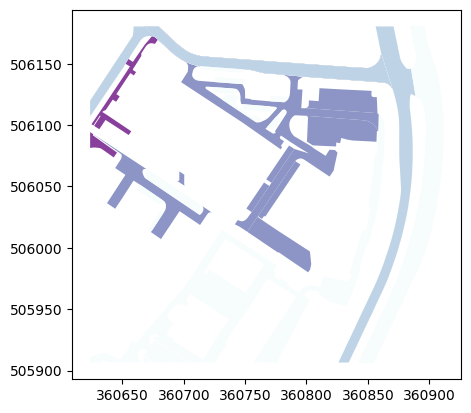

In [ ]:
import geopandas.plotting
from PIL import Image
from scipy.spatial.distance import cdist
from shapely import get_coordinates, set_coordinates

gdf = gdf.to_crs(epsg=2180)
ax = geopandas.plotting.plot_dataframe(gdf, legend=False, cmap="BuPu", column="material")

### Fit coordinates to image coordinates


Min (0.0;0.0)
Max (1158.1;1096.0)
Scale factor 0.74


ValueError: No valid geometry objects found for rasterize

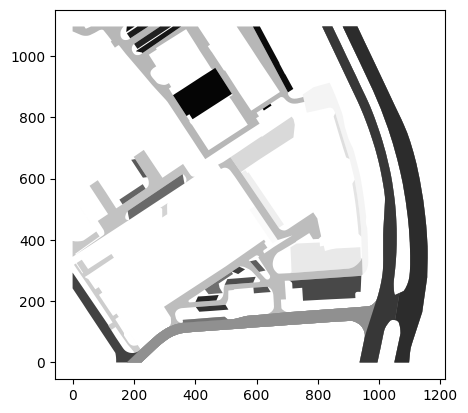

In [ ]:
min_x, min_y = 999999999999, 999999999999
max_x, max_y = 0, 0
for g in gdf.geometry:
    for coord in get_coordinates(g):
        [x, y] = coord
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x)
        max_y = max(max_y, y)
print(f"Min ({min_x};{min_y})\nMax ({max_x};{max_y})")

image_coords = []
# scale_factor = (road_img.shape[1] - (max_x - min_x)) / road_img.shape[1]
scale_factor = 0.74
print(f"Scale factor {scale_factor}")
for g in gdf.geometry:
    for coord in get_coordinates(g):
        [x, y] = coord
        x = (x - min_x) / (max_x - min_x) * 1565 * scale_factor
        y = 1096 - ((y - min_y) / (max_y - min_y) * 1096)
        image_coords.append([x, y])
set_coordinates(gdf.geometry, image_coords)

ax = geopandas.plotting.plot_dataframe(gdf, legend=False, cmap="binary", color="black", k=0)
ax.imshow(Image.open("./buildings.png", "r"))

In [ ]:
# Extract coordinates from the GeoJSON polygon
geojson_coords = np.array(image_coords)

# Extract coordinates from the road mask
road_mask_coords = np.argwhere(mask > 0)

# Compute pairwise distances between GeoJSON and road mask coordinates
distances = cdist(geojson_coords, road_mask_coords)

# Find the minimum distance for each GeoJSON point
min_distances = distances.min(axis=1)

# Compute the average distance
average_distance = min_distances.mean()

print(f"Average image distance between GeoJSON plot and road mask: {average_distance}")


Average image distance between GeoJSON plot and road mask: 38.59639178944894
